# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [2]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

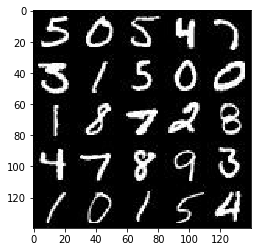

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

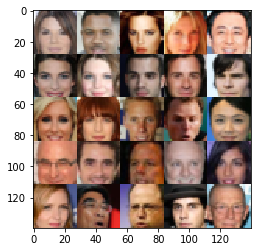

In [4]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [5]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.0.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [6]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    input_real = tf.placeholder(tf.float32, shape=(None, image_height, image_width, image_channels))
    input_z = tf.placeholder(tf.float32, shape=(None, z_dim))
    learning_rate = tf.placeholder(tf.float32, shape=())

    return input_real, input_z, learning_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


In [7]:
def lrelu(x, alpha):
    return tf.maximum(x * alpha, x)

### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [8]:
def discriminator(images, reuse=False, alpha=0.1):
    """
    Create the discriminator network
    :param image: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # TODO: Implement Function
    
    kinit = tf.random_normal_initializer(stddev=0.02)
    
    with tf.variable_scope('discriminator', reuse=reuse):
        # Input is 28x28x3
        x = tf.layers.conv2d(images, 64, 5, strides=2, kernel_initializer=kinit, padding='same')
        x = lrelu(x, alpha)
        # 14x14x64
        
        x = tf.layers.conv2d(x, 128, 5, strides=2, kernel_initializer=kinit, padding='same')
        x = lrelu(x, alpha)
        x = tf.layers.batch_normalization(x, training=True)
        # 7x7x128
        
        x = tf.layers.conv2d(x, 256, 5, strides=2, kernel_initializer=kinit, padding='same')
        x = lrelu(x, alpha)
        x = tf.layers.batch_normalization(x, training=True)
        # 4x4x256
        
        x = tf.reshape(x, (-1, 4*4*256))
        logits = tf.layers.dense(x, 1)
        out = tf.sigmoid(logits)

    return out, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [9]:
def generator(z, out_channel_dim, is_train=True, alpha=0.1):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # TODO: Implement Function
    
    kinit = tf.random_normal_initializer(stddev=0.02)
    
    with tf.variable_scope('generator', reuse=(not is_train)):
        x = tf.layers.dense(z, 7*7*256)
        x = tf.reshape(x, (-1, 7, 7, 256))
        x = lrelu(x, alpha)
        x = tf.layers.batch_normalization(x, training=is_train)
        # 7x7x256
        
        x = tf.layers.conv2d_transpose(x, 128, 5, strides=2, kernel_initializer=kinit, padding='same')
        x = lrelu(x, alpha)
        x = tf.layers.batch_normalization(x, training=is_train)
        # 14x14x128
        
        x = tf.layers.conv2d_transpose(x, 64, 5, strides=2, kernel_initializer=kinit, padding='same')
        x = lrelu(x, alpha)
        x = tf.layers.batch_normalization(x, training=is_train)
        # 28x28x64
        
        logits = tf.layers.conv2d_transpose(x, out_channel_dim, 3, strides=1, kernel_initializer=kinit, padding='same')
        # 28x28x3
        
        out = tf.tanh(logits)
    
    return out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [10]:
def model_loss(input_real, input_z, out_channel_dim, alpha=0.1):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    g_model = generator(input_z, out_channel_dim, is_train=True, alpha=alpha)
    d_real_out, d_real_logits = discriminator(input_real, alpha=alpha)
    d_fake_out, d_fake_logits = discriminator(g_model, reuse=True, alpha=alpha)
    
    smooth = 0.1
    real_labels = tf.ones_like(d_real_out) * (1 - smooth)
    fake_labels = tf.zeros_like(d_fake_out)
    g_labels    = tf.ones_like(d_fake_out)

    d_real_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_real_logits, labels=real_labels))
    d_fake_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_fake_logits, labels=fake_labels))
    g_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_fake_logits, labels=g_labels))

    d_loss = d_real_loss + d_fake_loss
    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [11]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]
    
    update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
    d_updates = [opt for opt in update_ops if opt.name.startswith('discriminator')]
    g_updates = [opt for opt in update_ops if opt.name.startswith('generator')]

    with tf.control_dependencies(d_updates):
        d_opt = tf.train.AdamOptimizer(learning_rate=learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)

    with tf.control_dependencies(g_updates):
        g_opt = tf.train.AdamOptimizer(learning_rate=learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)
            
    return d_opt, g_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [12]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [13]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode,
          print_every=10, show_every=100):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model
    input_real, input_z, lr = model_inputs(data_shape[1], data_shape[2], data_shape[3], z_dim)
    d_loss, g_loss = model_loss(input_real, input_z, data_shape[3], alpha=0.2)
    d_opt, g_opt = model_opt(d_loss, g_loss, learning_rate, beta1)
    
    steps = 0
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                # TODO: Train Model
                steps += 1
                batch_images *= 2.0
                
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))
                
                _ = sess.run(d_opt, feed_dict={input_real: batch_images, input_z: batch_z})
                _ = sess.run(g_opt, feed_dict={input_z: batch_z})

                if steps % print_every == 0:
                    train_loss_d = d_loss.eval({input_z: batch_z, input_real: batch_images})
                    train_loss_g = g_loss.eval({input_z: batch_z})

                    print("Epoch {}/{}...".format(epoch_i + 1, epochs),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))

                if steps % show_every == 0:
                    show_generator_output(sess, 25, input_z, data_shape[3], data_image_mode)


### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2... Discriminator Loss: 0.9184... Generator Loss: 0.9962
Epoch 1/2... Discriminator Loss: 0.5036... Generator Loss: 2.2103
Epoch 1/2... Discriminator Loss: 0.4624... Generator Loss: 2.4705
Epoch 1/2... Discriminator Loss: 0.3995... Generator Loss: 3.2178
Epoch 1/2... Discriminator Loss: 0.3967... Generator Loss: 3.8893
Epoch 1/2... Discriminator Loss: 0.5010... Generator Loss: 3.4189
Epoch 1/2... Discriminator Loss: 0.3499... Generator Loss: 6.3886
Epoch 1/2... Discriminator Loss: 0.3553... Generator Loss: 4.2437
Epoch 1/2... Discriminator Loss: 0.3596... Generator Loss: 4.0651
Epoch 1/2... Discriminator Loss: 0.3903... Generator Loss: 4.4864


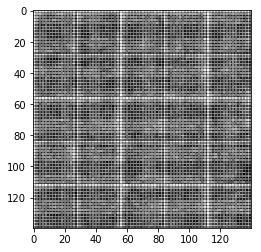

Epoch 1/2... Discriminator Loss: 0.3532... Generator Loss: 4.4161
Epoch 1/2... Discriminator Loss: 0.3746... Generator Loss: 3.9315
Epoch 1/2... Discriminator Loss: 0.3543... Generator Loss: 4.3246
Epoch 1/2... Discriminator Loss: 0.3659... Generator Loss: 4.1797
Epoch 1/2... Discriminator Loss: 0.4177... Generator Loss: 4.0555
Epoch 1/2... Discriminator Loss: 0.3735... Generator Loss: 4.3386
Epoch 1/2... Discriminator Loss: 0.5315... Generator Loss: 3.4811
Epoch 1/2... Discriminator Loss: 0.3540... Generator Loss: 4.3763
Epoch 1/2... Discriminator Loss: 0.3506... Generator Loss: 4.6699
Epoch 1/2... Discriminator Loss: 0.3942... Generator Loss: 4.4079


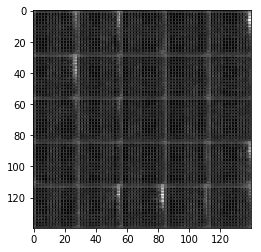

Epoch 1/2... Discriminator Loss: 0.4085... Generator Loss: 5.6829
Epoch 1/2... Discriminator Loss: 0.3486... Generator Loss: 5.0013
Epoch 1/2... Discriminator Loss: 0.3765... Generator Loss: 4.8047
Epoch 1/2... Discriminator Loss: 0.4703... Generator Loss: 3.1856
Epoch 1/2... Discriminator Loss: 0.5862... Generator Loss: 2.2976
Epoch 1/2... Discriminator Loss: 0.5196... Generator Loss: 3.5454
Epoch 1/2... Discriminator Loss: 1.1328... Generator Loss: 3.2606
Epoch 1/2... Discriminator Loss: 0.5767... Generator Loss: 1.8314
Epoch 1/2... Discriminator Loss: 0.4891... Generator Loss: 2.3335
Epoch 1/2... Discriminator Loss: 0.8287... Generator Loss: 1.1532


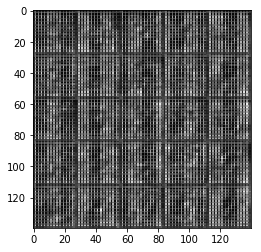

Epoch 1/2... Discriminator Loss: 0.6758... Generator Loss: 1.7553
Epoch 1/2... Discriminator Loss: 1.6963... Generator Loss: 5.9288
Epoch 1/2... Discriminator Loss: 0.6960... Generator Loss: 3.5199
Epoch 1/2... Discriminator Loss: 0.7550... Generator Loss: 1.2685
Epoch 1/2... Discriminator Loss: 0.6248... Generator Loss: 2.0715
Epoch 1/2... Discriminator Loss: 0.9798... Generator Loss: 3.7321
Epoch 1/2... Discriminator Loss: 0.6618... Generator Loss: 2.1198
Epoch 1/2... Discriminator Loss: 0.6353... Generator Loss: 1.9497
Epoch 1/2... Discriminator Loss: 0.6839... Generator Loss: 2.5065
Epoch 1/2... Discriminator Loss: 0.7700... Generator Loss: 1.2736


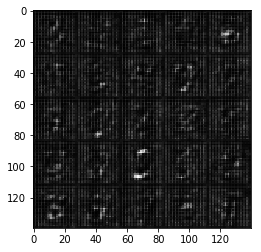

Epoch 1/2... Discriminator Loss: 0.6756... Generator Loss: 1.5616
Epoch 1/2... Discriminator Loss: 1.1821... Generator Loss: 0.6599
Epoch 1/2... Discriminator Loss: 0.7068... Generator Loss: 1.4362
Epoch 1/2... Discriminator Loss: 0.7696... Generator Loss: 2.9668
Epoch 1/2... Discriminator Loss: 0.7807... Generator Loss: 2.8183
Epoch 1/2... Discriminator Loss: 1.0654... Generator Loss: 0.7935
Epoch 1/2... Discriminator Loss: 0.6337... Generator Loss: 1.9630
Epoch 1/2... Discriminator Loss: 0.6386... Generator Loss: 2.2126
Epoch 1/2... Discriminator Loss: 0.7155... Generator Loss: 1.3357
Epoch 1/2... Discriminator Loss: 1.1668... Generator Loss: 0.6932


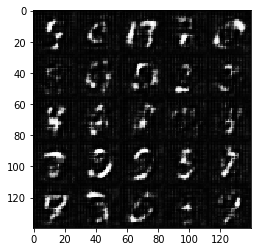

Epoch 1/2... Discriminator Loss: 0.6126... Generator Loss: 2.4706
Epoch 1/2... Discriminator Loss: 0.6907... Generator Loss: 1.6547
Epoch 1/2... Discriminator Loss: 0.7408... Generator Loss: 1.5518
Epoch 1/2... Discriminator Loss: 0.6958... Generator Loss: 1.8462
Epoch 1/2... Discriminator Loss: 0.6991... Generator Loss: 1.3607
Epoch 1/2... Discriminator Loss: 0.7264... Generator Loss: 1.3195
Epoch 1/2... Discriminator Loss: 0.6435... Generator Loss: 2.0757
Epoch 1/2... Discriminator Loss: 0.5834... Generator Loss: 2.0964
Epoch 1/2... Discriminator Loss: 0.5979... Generator Loss: 1.8680
Epoch 1/2... Discriminator Loss: 0.6811... Generator Loss: 1.7519


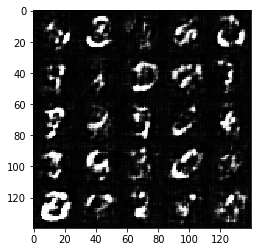

Epoch 1/2... Discriminator Loss: 0.5972... Generator Loss: 2.5566
Epoch 1/2... Discriminator Loss: 0.5877... Generator Loss: 2.4299
Epoch 1/2... Discriminator Loss: 0.7107... Generator Loss: 1.3855
Epoch 1/2... Discriminator Loss: 0.6205... Generator Loss: 1.9675
Epoch 1/2... Discriminator Loss: 0.8054... Generator Loss: 2.7349
Epoch 1/2... Discriminator Loss: 0.6846... Generator Loss: 1.5567
Epoch 1/2... Discriminator Loss: 0.8522... Generator Loss: 1.1661
Epoch 1/2... Discriminator Loss: 0.7197... Generator Loss: 1.4100
Epoch 1/2... Discriminator Loss: 0.8029... Generator Loss: 2.8383
Epoch 1/2... Discriminator Loss: 0.7160... Generator Loss: 1.8313


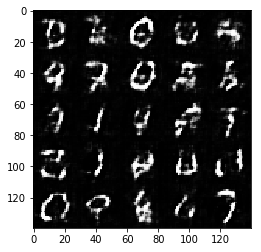

Epoch 1/2... Discriminator Loss: 0.6613... Generator Loss: 1.7685
Epoch 1/2... Discriminator Loss: 0.6877... Generator Loss: 1.5957
Epoch 1/2... Discriminator Loss: 0.7311... Generator Loss: 1.6538
Epoch 1/2... Discriminator Loss: 0.9866... Generator Loss: 0.9002
Epoch 1/2... Discriminator Loss: 0.9401... Generator Loss: 2.6140
Epoch 1/2... Discriminator Loss: 0.8312... Generator Loss: 1.3981
Epoch 1/2... Discriminator Loss: 0.7824... Generator Loss: 1.5282
Epoch 1/2... Discriminator Loss: 1.1115... Generator Loss: 0.7495
Epoch 1/2... Discriminator Loss: 0.7072... Generator Loss: 1.8708
Epoch 1/2... Discriminator Loss: 0.8542... Generator Loss: 1.3814


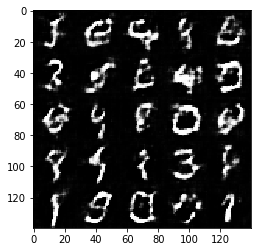

Epoch 1/2... Discriminator Loss: 0.7961... Generator Loss: 1.6003
Epoch 1/2... Discriminator Loss: 1.0301... Generator Loss: 0.9404
Epoch 1/2... Discriminator Loss: 0.8237... Generator Loss: 1.2996
Epoch 1/2... Discriminator Loss: 0.8151... Generator Loss: 1.2814
Epoch 1/2... Discriminator Loss: 0.8632... Generator Loss: 1.7227
Epoch 1/2... Discriminator Loss: 0.8496... Generator Loss: 1.9282
Epoch 1/2... Discriminator Loss: 0.7474... Generator Loss: 1.8838
Epoch 1/2... Discriminator Loss: 0.9390... Generator Loss: 1.0270
Epoch 1/2... Discriminator Loss: 0.8955... Generator Loss: 1.6337
Epoch 1/2... Discriminator Loss: 0.7267... Generator Loss: 1.7581


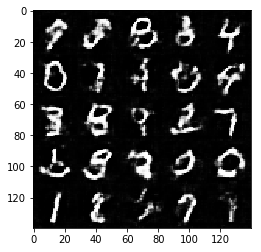

Epoch 1/2... Discriminator Loss: 0.8157... Generator Loss: 1.2250
Epoch 1/2... Discriminator Loss: 0.9430... Generator Loss: 1.0078
Epoch 1/2... Discriminator Loss: 0.7993... Generator Loss: 1.3060
Epoch 2/2... Discriminator Loss: 1.0661... Generator Loss: 2.0963
Epoch 2/2... Discriminator Loss: 0.8685... Generator Loss: 1.7556
Epoch 2/2... Discriminator Loss: 0.9369... Generator Loss: 0.9799
Epoch 2/2... Discriminator Loss: 0.9438... Generator Loss: 1.9530
Epoch 2/2... Discriminator Loss: 0.8361... Generator Loss: 1.2451
Epoch 2/2... Discriminator Loss: 0.8323... Generator Loss: 1.1324
Epoch 2/2... Discriminator Loss: 0.8626... Generator Loss: 1.3996


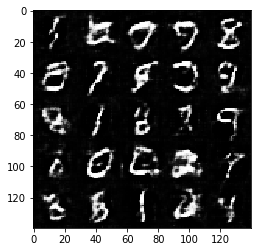

Epoch 2/2... Discriminator Loss: 0.9013... Generator Loss: 1.7605
Epoch 2/2... Discriminator Loss: 0.9498... Generator Loss: 1.0500
Epoch 2/2... Discriminator Loss: 0.8513... Generator Loss: 1.1591
Epoch 2/2... Discriminator Loss: 0.8263... Generator Loss: 1.2915
Epoch 2/2... Discriminator Loss: 0.8739... Generator Loss: 1.0985
Epoch 2/2... Discriminator Loss: 1.0123... Generator Loss: 0.8817
Epoch 2/2... Discriminator Loss: 1.0419... Generator Loss: 0.8504
Epoch 2/2... Discriminator Loss: 0.7478... Generator Loss: 1.6627
Epoch 2/2... Discriminator Loss: 0.8055... Generator Loss: 1.2594
Epoch 2/2... Discriminator Loss: 0.9121... Generator Loss: 1.1292


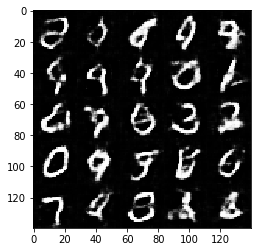

Epoch 2/2... Discriminator Loss: 0.9061... Generator Loss: 1.2499
Epoch 2/2... Discriminator Loss: 0.7735... Generator Loss: 1.2969
Epoch 2/2... Discriminator Loss: 0.8979... Generator Loss: 1.1625
Epoch 2/2... Discriminator Loss: 0.7763... Generator Loss: 2.1728
Epoch 2/2... Discriminator Loss: 0.9159... Generator Loss: 1.3639
Epoch 2/2... Discriminator Loss: 1.0426... Generator Loss: 0.7979
Epoch 2/2... Discriminator Loss: 0.8150... Generator Loss: 2.0046
Epoch 2/2... Discriminator Loss: 0.7684... Generator Loss: 1.9266
Epoch 2/2... Discriminator Loss: 0.7724... Generator Loss: 1.8613
Epoch 2/2... Discriminator Loss: 0.8526... Generator Loss: 1.1870


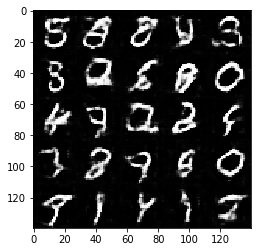

Epoch 2/2... Discriminator Loss: 0.8355... Generator Loss: 1.1929
Epoch 2/2... Discriminator Loss: 1.2858... Generator Loss: 0.5830
Epoch 2/2... Discriminator Loss: 0.8041... Generator Loss: 1.2373
Epoch 2/2... Discriminator Loss: 0.7819... Generator Loss: 1.3644
Epoch 2/2... Discriminator Loss: 1.1367... Generator Loss: 0.7471
Epoch 2/2... Discriminator Loss: 0.8031... Generator Loss: 1.2854
Epoch 2/2... Discriminator Loss: 0.8726... Generator Loss: 1.3412
Epoch 2/2... Discriminator Loss: 0.8487... Generator Loss: 1.2200
Epoch 2/2... Discriminator Loss: 0.8994... Generator Loss: 1.8939
Epoch 2/2... Discriminator Loss: 0.8880... Generator Loss: 1.6535


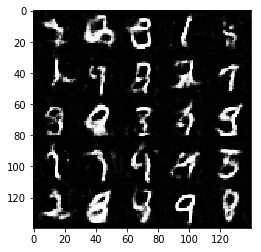

Epoch 2/2... Discriminator Loss: 0.7683... Generator Loss: 1.3301
Epoch 2/2... Discriminator Loss: 0.8618... Generator Loss: 2.0660
Epoch 2/2... Discriminator Loss: 0.7780... Generator Loss: 1.4964
Epoch 2/2... Discriminator Loss: 0.9109... Generator Loss: 1.0786
Epoch 2/2... Discriminator Loss: 0.7687... Generator Loss: 1.6333
Epoch 2/2... Discriminator Loss: 0.8309... Generator Loss: 1.4415
Epoch 2/2... Discriminator Loss: 0.8623... Generator Loss: 1.0766
Epoch 2/2... Discriminator Loss: 1.0091... Generator Loss: 0.8285
Epoch 2/2... Discriminator Loss: 0.8150... Generator Loss: 1.5670
Epoch 2/2... Discriminator Loss: 1.1508... Generator Loss: 0.7163


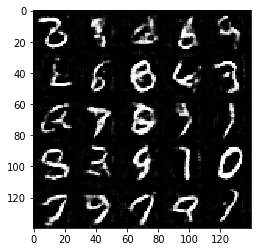

Epoch 2/2... Discriminator Loss: 0.7839... Generator Loss: 1.5086
Epoch 2/2... Discriminator Loss: 0.9411... Generator Loss: 0.9960
Epoch 2/2... Discriminator Loss: 0.8695... Generator Loss: 1.0764
Epoch 2/2... Discriminator Loss: 1.0455... Generator Loss: 0.7656
Epoch 2/2... Discriminator Loss: 0.7785... Generator Loss: 1.5177
Epoch 2/2... Discriminator Loss: 0.8393... Generator Loss: 1.1839
Epoch 2/2... Discriminator Loss: 0.8995... Generator Loss: 1.0322
Epoch 2/2... Discriminator Loss: 0.7654... Generator Loss: 1.7238
Epoch 2/2... Discriminator Loss: 0.8457... Generator Loss: 1.1554
Epoch 2/2... Discriminator Loss: 0.8958... Generator Loss: 1.2224


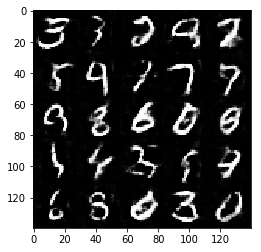

Epoch 2/2... Discriminator Loss: 0.6647... Generator Loss: 1.8522
Epoch 2/2... Discriminator Loss: 1.2888... Generator Loss: 0.5977
Epoch 2/2... Discriminator Loss: 0.7893... Generator Loss: 1.2212
Epoch 2/2... Discriminator Loss: 0.8110... Generator Loss: 1.2215
Epoch 2/2... Discriminator Loss: 0.8032... Generator Loss: 1.2142
Epoch 2/2... Discriminator Loss: 0.8670... Generator Loss: 1.4998
Epoch 2/2... Discriminator Loss: 0.8837... Generator Loss: 1.0637
Epoch 2/2... Discriminator Loss: 0.7395... Generator Loss: 1.4813
Epoch 2/2... Discriminator Loss: 0.8878... Generator Loss: 2.2767
Epoch 2/2... Discriminator Loss: 0.7673... Generator Loss: 1.3826


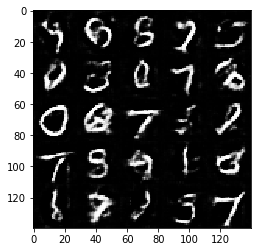

Epoch 2/2... Discriminator Loss: 0.7330... Generator Loss: 1.5435
Epoch 2/2... Discriminator Loss: 0.7207... Generator Loss: 1.5333
Epoch 2/2... Discriminator Loss: 0.9276... Generator Loss: 0.9944
Epoch 2/2... Discriminator Loss: 0.7409... Generator Loss: 1.4549
Epoch 2/2... Discriminator Loss: 0.8553... Generator Loss: 1.4763
Epoch 2/2... Discriminator Loss: 0.7215... Generator Loss: 1.6971
Epoch 2/2... Discriminator Loss: 0.9167... Generator Loss: 1.0285
Epoch 2/2... Discriminator Loss: 0.7640... Generator Loss: 1.5069
Epoch 2/2... Discriminator Loss: 0.7556... Generator Loss: 1.2957
Epoch 2/2... Discriminator Loss: 0.7228... Generator Loss: 1.5508


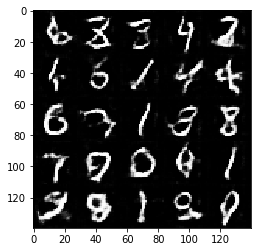

Epoch 2/2... Discriminator Loss: 1.2162... Generator Loss: 2.6840
Epoch 2/2... Discriminator Loss: 0.9103... Generator Loss: 0.9785
Epoch 2/2... Discriminator Loss: 0.9268... Generator Loss: 1.0123
Epoch 2/2... Discriminator Loss: 0.8784... Generator Loss: 2.5206
Epoch 2/2... Discriminator Loss: 0.6792... Generator Loss: 1.8553
Epoch 2/2... Discriminator Loss: 0.6716... Generator Loss: 1.6638
Epoch 2/2... Discriminator Loss: 0.8035... Generator Loss: 1.3127
Epoch 2/2... Discriminator Loss: 0.9531... Generator Loss: 0.9038
Epoch 2/2... Discriminator Loss: 0.8211... Generator Loss: 1.1177
Epoch 2/2... Discriminator Loss: 0.8012... Generator Loss: 2.4050


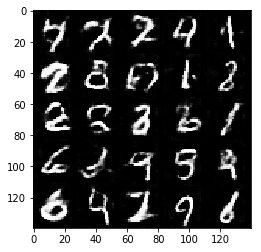

Epoch 2/2... Discriminator Loss: 1.0415... Generator Loss: 0.8209
Epoch 2/2... Discriminator Loss: 0.8353... Generator Loss: 1.1739
Epoch 2/2... Discriminator Loss: 0.7573... Generator Loss: 1.3741
Epoch 2/2... Discriminator Loss: 0.8605... Generator Loss: 1.1051
Epoch 2/2... Discriminator Loss: 0.9767... Generator Loss: 0.8742
Epoch 2/2... Discriminator Loss: 0.7000... Generator Loss: 1.5079
Epoch 2/2... Discriminator Loss: 0.7693... Generator Loss: 1.9760


In [14]:
batch_size = 64
z_dim = 100
learning_rate = 0.0001
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/1... Discriminator Loss: 2.4382... Generator Loss: 0.2165
Epoch 1/1... Discriminator Loss: 1.5336... Generator Loss: 0.6293
Epoch 1/1... Discriminator Loss: 0.9319... Generator Loss: 1.0999
Epoch 1/1... Discriminator Loss: 0.7772... Generator Loss: 1.5432
Epoch 1/1... Discriminator Loss: 0.7312... Generator Loss: 1.6440
Epoch 1/1... Discriminator Loss: 0.6210... Generator Loss: 1.8603
Epoch 1/1... Discriminator Loss: 0.7182... Generator Loss: 2.5001
Epoch 1/1... Discriminator Loss: 0.7009... Generator Loss: 1.6613
Epoch 1/1... Discriminator Loss: 0.6938... Generator Loss: 1.6920
Epoch 1/1... Discriminator Loss: 2.4249... Generator Loss: 0.2611


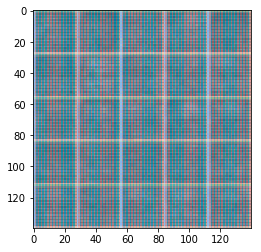

Epoch 1/1... Discriminator Loss: 0.5956... Generator Loss: 2.2910
Epoch 1/1... Discriminator Loss: 0.7192... Generator Loss: 1.8220
Epoch 1/1... Discriminator Loss: 2.1023... Generator Loss: 6.1265
Epoch 1/1... Discriminator Loss: 1.5734... Generator Loss: 0.5645
Epoch 1/1... Discriminator Loss: 1.0431... Generator Loss: 1.4401
Epoch 1/1... Discriminator Loss: 1.2824... Generator Loss: 2.6214
Epoch 1/1... Discriminator Loss: 1.1281... Generator Loss: 0.7552
Epoch 1/1... Discriminator Loss: 1.2829... Generator Loss: 0.7241
Epoch 1/1... Discriminator Loss: 0.8095... Generator Loss: 2.0802
Epoch 1/1... Discriminator Loss: 1.1659... Generator Loss: 0.9459


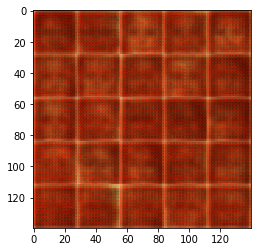

Epoch 1/1... Discriminator Loss: 0.8417... Generator Loss: 1.8249
Epoch 1/1... Discriminator Loss: 1.9189... Generator Loss: 3.5270
Epoch 1/1... Discriminator Loss: 2.2410... Generator Loss: 0.1850
Epoch 1/1... Discriminator Loss: 0.9224... Generator Loss: 1.2894
Epoch 1/1... Discriminator Loss: 0.9035... Generator Loss: 2.0932
Epoch 1/1... Discriminator Loss: 1.1609... Generator Loss: 1.1096
Epoch 1/1... Discriminator Loss: 0.8355... Generator Loss: 1.5086
Epoch 1/1... Discriminator Loss: 1.0018... Generator Loss: 1.0104
Epoch 1/1... Discriminator Loss: 1.1852... Generator Loss: 0.6928
Epoch 1/1... Discriminator Loss: 1.3982... Generator Loss: 0.8749


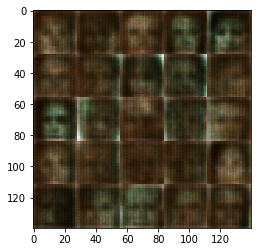

Epoch 1/1... Discriminator Loss: 1.2765... Generator Loss: 0.6034
Epoch 1/1... Discriminator Loss: 1.5222... Generator Loss: 0.4903
Epoch 1/1... Discriminator Loss: 1.0780... Generator Loss: 1.7481
Epoch 1/1... Discriminator Loss: 1.2665... Generator Loss: 0.7197
Epoch 1/1... Discriminator Loss: 0.9899... Generator Loss: 0.9418
Epoch 1/1... Discriminator Loss: 1.5670... Generator Loss: 0.5316
Epoch 1/1... Discriminator Loss: 1.0785... Generator Loss: 1.1619
Epoch 1/1... Discriminator Loss: 1.5392... Generator Loss: 0.4813
Epoch 1/1... Discriminator Loss: 1.5104... Generator Loss: 0.5038
Epoch 1/1... Discriminator Loss: 1.5915... Generator Loss: 0.4412


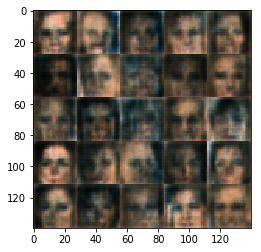

Epoch 1/1... Discriminator Loss: 1.3708... Generator Loss: 1.3239
Epoch 1/1... Discriminator Loss: 1.8529... Generator Loss: 0.3714
Epoch 1/1... Discriminator Loss: 1.3143... Generator Loss: 0.8764
Epoch 1/1... Discriminator Loss: 1.2923... Generator Loss: 0.8218
Epoch 1/1... Discriminator Loss: 1.1404... Generator Loss: 1.1303
Epoch 1/1... Discriminator Loss: 1.3087... Generator Loss: 1.0202
Epoch 1/1... Discriminator Loss: 1.6792... Generator Loss: 0.4445
Epoch 1/1... Discriminator Loss: 1.6102... Generator Loss: 0.6051
Epoch 1/1... Discriminator Loss: 1.3656... Generator Loss: 0.6289
Epoch 1/1... Discriminator Loss: 1.3864... Generator Loss: 1.1716


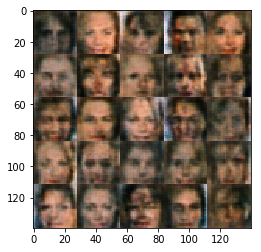

Epoch 1/1... Discriminator Loss: 1.1309... Generator Loss: 0.9982
Epoch 1/1... Discriminator Loss: 1.5193... Generator Loss: 0.4598
Epoch 1/1... Discriminator Loss: 1.4448... Generator Loss: 0.5691
Epoch 1/1... Discriminator Loss: 1.3007... Generator Loss: 0.6288
Epoch 1/1... Discriminator Loss: 1.4253... Generator Loss: 0.8533
Epoch 1/1... Discriminator Loss: 1.2467... Generator Loss: 1.0647
Epoch 1/1... Discriminator Loss: 1.4588... Generator Loss: 0.6791
Epoch 1/1... Discriminator Loss: 1.1692... Generator Loss: 1.2629
Epoch 1/1... Discriminator Loss: 1.1359... Generator Loss: 0.7949
Epoch 1/1... Discriminator Loss: 1.2682... Generator Loss: 0.6911


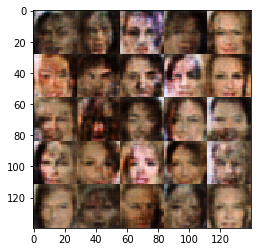

Epoch 1/1... Discriminator Loss: 1.3814... Generator Loss: 0.6069
Epoch 1/1... Discriminator Loss: 1.3745... Generator Loss: 0.6912
Epoch 1/1... Discriminator Loss: 1.4445... Generator Loss: 0.7329
Epoch 1/1... Discriminator Loss: 1.3374... Generator Loss: 0.6699
Epoch 1/1... Discriminator Loss: 1.1559... Generator Loss: 0.9105
Epoch 1/1... Discriminator Loss: 1.2652... Generator Loss: 1.1038
Epoch 1/1... Discriminator Loss: 1.2799... Generator Loss: 0.7683
Epoch 1/1... Discriminator Loss: 1.2260... Generator Loss: 0.6492
Epoch 1/1... Discriminator Loss: 1.1462... Generator Loss: 0.9453
Epoch 1/1... Discriminator Loss: 1.1499... Generator Loss: 1.1499


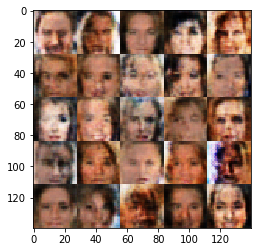

Epoch 1/1... Discriminator Loss: 1.3355... Generator Loss: 1.1440
Epoch 1/1... Discriminator Loss: 1.1520... Generator Loss: 1.1831
Epoch 1/1... Discriminator Loss: 1.3123... Generator Loss: 0.6171
Epoch 1/1... Discriminator Loss: 1.1854... Generator Loss: 1.4236
Epoch 1/1... Discriminator Loss: 1.4849... Generator Loss: 1.1200
Epoch 1/1... Discriminator Loss: 1.4540... Generator Loss: 0.7104
Epoch 1/1... Discriminator Loss: 1.1424... Generator Loss: 0.8835
Epoch 1/1... Discriminator Loss: 1.6094... Generator Loss: 0.4570
Epoch 1/1... Discriminator Loss: 1.2370... Generator Loss: 0.8228
Epoch 1/1... Discriminator Loss: 1.2895... Generator Loss: 0.7051


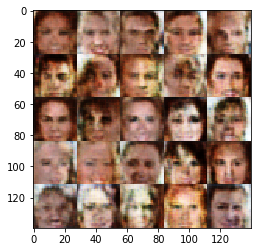

Epoch 1/1... Discriminator Loss: 1.1970... Generator Loss: 0.7610
Epoch 1/1... Discriminator Loss: 1.0967... Generator Loss: 0.9544
Epoch 1/1... Discriminator Loss: 0.9682... Generator Loss: 1.1411
Epoch 1/1... Discriminator Loss: 1.2335... Generator Loss: 1.0998
Epoch 1/1... Discriminator Loss: 1.3161... Generator Loss: 0.7414
Epoch 1/1... Discriminator Loss: 1.1876... Generator Loss: 0.8190
Epoch 1/1... Discriminator Loss: 1.2853... Generator Loss: 0.7090
Epoch 1/1... Discriminator Loss: 1.2054... Generator Loss: 0.8586
Epoch 1/1... Discriminator Loss: 1.1464... Generator Loss: 1.3981
Epoch 1/1... Discriminator Loss: 1.3226... Generator Loss: 0.7845


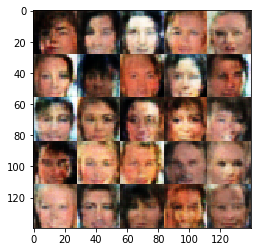

Epoch 1/1... Discriminator Loss: 1.2582... Generator Loss: 0.6264
Epoch 1/1... Discriminator Loss: 1.0974... Generator Loss: 0.8659
Epoch 1/1... Discriminator Loss: 1.2340... Generator Loss: 0.7979
Epoch 1/1... Discriminator Loss: 1.3426... Generator Loss: 0.5564
Epoch 1/1... Discriminator Loss: 1.1758... Generator Loss: 0.8127
Epoch 1/1... Discriminator Loss: 1.1257... Generator Loss: 1.1415
Epoch 1/1... Discriminator Loss: 1.2640... Generator Loss: 0.7332
Epoch 1/1... Discriminator Loss: 1.0391... Generator Loss: 1.2003
Epoch 1/1... Discriminator Loss: 1.2891... Generator Loss: 0.7630
Epoch 1/1... Discriminator Loss: 1.3042... Generator Loss: 0.8663


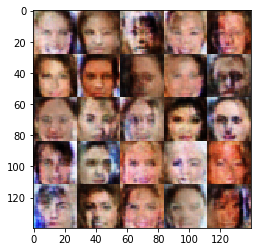

Epoch 1/1... Discriminator Loss: 1.5094... Generator Loss: 0.5947
Epoch 1/1... Discriminator Loss: 1.1267... Generator Loss: 0.9230
Epoch 1/1... Discriminator Loss: 1.2068... Generator Loss: 0.9096
Epoch 1/1... Discriminator Loss: 1.0951... Generator Loss: 1.1652
Epoch 1/1... Discriminator Loss: 1.3148... Generator Loss: 1.0298
Epoch 1/1... Discriminator Loss: 1.2043... Generator Loss: 0.8912
Epoch 1/1... Discriminator Loss: 1.1770... Generator Loss: 0.7814
Epoch 1/1... Discriminator Loss: 1.2719... Generator Loss: 0.7544
Epoch 1/1... Discriminator Loss: 1.3988... Generator Loss: 0.7473
Epoch 1/1... Discriminator Loss: 1.1952... Generator Loss: 0.9791


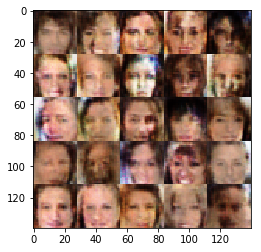

Epoch 1/1... Discriminator Loss: 1.0522... Generator Loss: 1.0436
Epoch 1/1... Discriminator Loss: 1.4798... Generator Loss: 0.5899
Epoch 1/1... Discriminator Loss: 1.3784... Generator Loss: 0.9298
Epoch 1/1... Discriminator Loss: 1.4310... Generator Loss: 0.8184
Epoch 1/1... Discriminator Loss: 1.2723... Generator Loss: 1.2483
Epoch 1/1... Discriminator Loss: 1.2370... Generator Loss: 0.7154
Epoch 1/1... Discriminator Loss: 1.5391... Generator Loss: 0.5332
Epoch 1/1... Discriminator Loss: 1.2393... Generator Loss: 0.8484
Epoch 1/1... Discriminator Loss: 1.0473... Generator Loss: 0.9721
Epoch 1/1... Discriminator Loss: 1.2007... Generator Loss: 0.7729


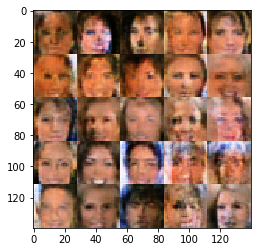

Epoch 1/1... Discriminator Loss: 1.4224... Generator Loss: 0.5723
Epoch 1/1... Discriminator Loss: 1.3504... Generator Loss: 0.6516
Epoch 1/1... Discriminator Loss: 1.3409... Generator Loss: 0.5280
Epoch 1/1... Discriminator Loss: 1.5667... Generator Loss: 0.4000
Epoch 1/1... Discriminator Loss: 1.0332... Generator Loss: 1.0018
Epoch 1/1... Discriminator Loss: 1.1924... Generator Loss: 0.8137
Epoch 1/1... Discriminator Loss: 1.5026... Generator Loss: 0.5481
Epoch 1/1... Discriminator Loss: 1.0969... Generator Loss: 0.8829
Epoch 1/1... Discriminator Loss: 1.3951... Generator Loss: 0.5638
Epoch 1/1... Discriminator Loss: 1.4562... Generator Loss: 0.5257


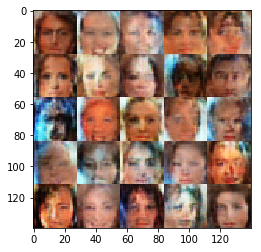

Epoch 1/1... Discriminator Loss: 1.3272... Generator Loss: 0.6370
Epoch 1/1... Discriminator Loss: 1.1097... Generator Loss: 0.7836
Epoch 1/1... Discriminator Loss: 1.1304... Generator Loss: 0.8911
Epoch 1/1... Discriminator Loss: 1.0510... Generator Loss: 1.1266
Epoch 1/1... Discriminator Loss: 1.1417... Generator Loss: 1.4486
Epoch 1/1... Discriminator Loss: 1.2303... Generator Loss: 0.7360
Epoch 1/1... Discriminator Loss: 1.1647... Generator Loss: 0.7958
Epoch 1/1... Discriminator Loss: 1.1423... Generator Loss: 0.7439
Epoch 1/1... Discriminator Loss: 1.0994... Generator Loss: 0.9470
Epoch 1/1... Discriminator Loss: 1.2196... Generator Loss: 0.7909


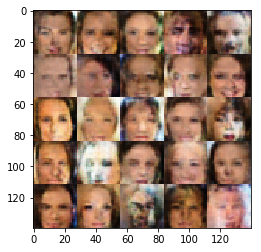

Epoch 1/1... Discriminator Loss: 1.3788... Generator Loss: 0.6561
Epoch 1/1... Discriminator Loss: 1.1545... Generator Loss: 0.7278
Epoch 1/1... Discriminator Loss: 1.0847... Generator Loss: 0.9819
Epoch 1/1... Discriminator Loss: 1.1775... Generator Loss: 0.8057
Epoch 1/1... Discriminator Loss: 1.3866... Generator Loss: 0.5833
Epoch 1/1... Discriminator Loss: 1.0571... Generator Loss: 1.1511
Epoch 1/1... Discriminator Loss: 1.8898... Generator Loss: 0.3629
Epoch 1/1... Discriminator Loss: 1.2357... Generator Loss: 0.6964
Epoch 1/1... Discriminator Loss: 1.3219... Generator Loss: 0.6612
Epoch 1/1... Discriminator Loss: 1.2762... Generator Loss: 0.6055


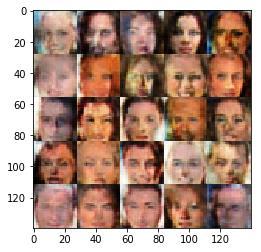

Epoch 1/1... Discriminator Loss: 1.1244... Generator Loss: 0.8268
Epoch 1/1... Discriminator Loss: 1.2177... Generator Loss: 0.7738
Epoch 1/1... Discriminator Loss: 1.3904... Generator Loss: 0.6882
Epoch 1/1... Discriminator Loss: 1.2131... Generator Loss: 0.8068
Epoch 1/1... Discriminator Loss: 1.0819... Generator Loss: 1.1184
Epoch 1/1... Discriminator Loss: 1.2222... Generator Loss: 0.9284
Epoch 1/1... Discriminator Loss: 1.1114... Generator Loss: 0.7765
Epoch 1/1... Discriminator Loss: 1.3796... Generator Loss: 0.5628
Epoch 1/1... Discriminator Loss: 1.2836... Generator Loss: 0.7033
Epoch 1/1... Discriminator Loss: 1.0807... Generator Loss: 1.2900


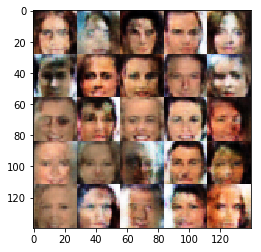

Epoch 1/1... Discriminator Loss: 1.2389... Generator Loss: 0.9731
Epoch 1/1... Discriminator Loss: 1.5283... Generator Loss: 0.5167
Epoch 1/1... Discriminator Loss: 1.1439... Generator Loss: 1.1407
Epoch 1/1... Discriminator Loss: 1.2720... Generator Loss: 0.6714
Epoch 1/1... Discriminator Loss: 1.2234... Generator Loss: 0.8887
Epoch 1/1... Discriminator Loss: 1.4925... Generator Loss: 0.5640
Epoch 1/1... Discriminator Loss: 1.2474... Generator Loss: 0.7563
Epoch 1/1... Discriminator Loss: 1.2784... Generator Loss: 0.7309
Epoch 1/1... Discriminator Loss: 1.0800... Generator Loss: 1.0375
Epoch 1/1... Discriminator Loss: 1.1982... Generator Loss: 0.7396


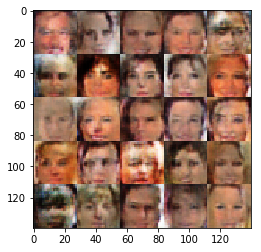

Epoch 1/1... Discriminator Loss: 1.2356... Generator Loss: 0.7869
Epoch 1/1... Discriminator Loss: 1.0110... Generator Loss: 1.3265
Epoch 1/1... Discriminator Loss: 1.2393... Generator Loss: 0.7133
Epoch 1/1... Discriminator Loss: 1.2433... Generator Loss: 0.9008
Epoch 1/1... Discriminator Loss: 1.0222... Generator Loss: 1.4206
Epoch 1/1... Discriminator Loss: 1.4534... Generator Loss: 0.5013
Epoch 1/1... Discriminator Loss: 1.2177... Generator Loss: 0.8635
Epoch 1/1... Discriminator Loss: 1.1461... Generator Loss: 1.0013
Epoch 1/1... Discriminator Loss: 1.1067... Generator Loss: 0.9746
Epoch 1/1... Discriminator Loss: 1.9349... Generator Loss: 0.3359


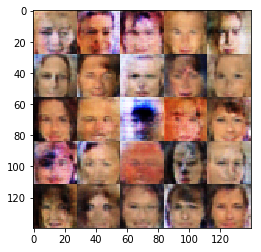

Epoch 1/1... Discriminator Loss: 1.0210... Generator Loss: 0.9678
Epoch 1/1... Discriminator Loss: 1.3500... Generator Loss: 0.9529
Epoch 1/1... Discriminator Loss: 1.2871... Generator Loss: 0.6744
Epoch 1/1... Discriminator Loss: 1.1246... Generator Loss: 1.2782
Epoch 1/1... Discriminator Loss: 0.8976... Generator Loss: 1.0401
Epoch 1/1... Discriminator Loss: 1.4152... Generator Loss: 0.6109
Epoch 1/1... Discriminator Loss: 1.3049... Generator Loss: 0.6417
Epoch 1/1... Discriminator Loss: 1.3396... Generator Loss: 0.5601
Epoch 1/1... Discriminator Loss: 1.2093... Generator Loss: 0.7950
Epoch 1/1... Discriminator Loss: 1.3543... Generator Loss: 0.6098


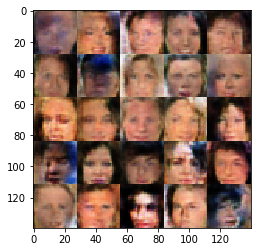

Epoch 1/1... Discriminator Loss: 1.5879... Generator Loss: 0.4023
Epoch 1/1... Discriminator Loss: 1.4876... Generator Loss: 0.5194
Epoch 1/1... Discriminator Loss: 1.1811... Generator Loss: 0.8016
Epoch 1/1... Discriminator Loss: 1.4833... Generator Loss: 0.5634
Epoch 1/1... Discriminator Loss: 1.2407... Generator Loss: 1.2379
Epoch 1/1... Discriminator Loss: 1.1990... Generator Loss: 0.8738
Epoch 1/1... Discriminator Loss: 1.2166... Generator Loss: 0.8196
Epoch 1/1... Discriminator Loss: 1.2028... Generator Loss: 0.8038
Epoch 1/1... Discriminator Loss: 1.2111... Generator Loss: 0.6904
Epoch 1/1... Discriminator Loss: 1.2683... Generator Loss: 0.6716


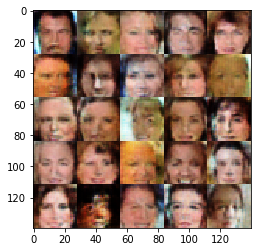

Epoch 1/1... Discriminator Loss: 1.1297... Generator Loss: 0.8640
Epoch 1/1... Discriminator Loss: 1.5532... Generator Loss: 0.4492
Epoch 1/1... Discriminator Loss: 1.2631... Generator Loss: 0.6719
Epoch 1/1... Discriminator Loss: 1.1408... Generator Loss: 0.7800
Epoch 1/1... Discriminator Loss: 1.1047... Generator Loss: 0.9469
Epoch 1/1... Discriminator Loss: 1.1835... Generator Loss: 1.0857
Epoch 1/1... Discriminator Loss: 1.1987... Generator Loss: 0.9039
Epoch 1/1... Discriminator Loss: 1.3907... Generator Loss: 0.7792
Epoch 1/1... Discriminator Loss: 1.1804... Generator Loss: 0.6928
Epoch 1/1... Discriminator Loss: 1.2131... Generator Loss: 0.6902


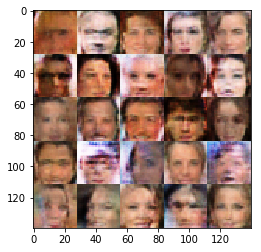

Epoch 1/1... Discriminator Loss: 1.0971... Generator Loss: 0.7772
Epoch 1/1... Discriminator Loss: 1.2355... Generator Loss: 0.8314
Epoch 1/1... Discriminator Loss: 1.4067... Generator Loss: 0.5046
Epoch 1/1... Discriminator Loss: 1.3471... Generator Loss: 0.6326
Epoch 1/1... Discriminator Loss: 1.0602... Generator Loss: 0.9581
Epoch 1/1... Discriminator Loss: 1.1830... Generator Loss: 0.6890
Epoch 1/1... Discriminator Loss: 1.2193... Generator Loss: 0.7874
Epoch 1/1... Discriminator Loss: 1.3531... Generator Loss: 0.5965
Epoch 1/1... Discriminator Loss: 1.1073... Generator Loss: 0.8487
Epoch 1/1... Discriminator Loss: 1.1661... Generator Loss: 0.8409


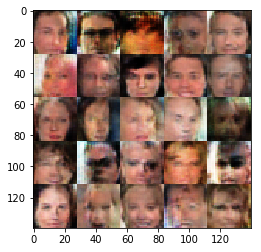

Epoch 1/1... Discriminator Loss: 1.5046... Generator Loss: 0.4443
Epoch 1/1... Discriminator Loss: 1.3045... Generator Loss: 0.6015
Epoch 1/1... Discriminator Loss: 1.1058... Generator Loss: 1.0658
Epoch 1/1... Discriminator Loss: 1.3527... Generator Loss: 0.7094
Epoch 1/1... Discriminator Loss: 1.3104... Generator Loss: 0.7746
Epoch 1/1... Discriminator Loss: 0.9709... Generator Loss: 0.9310
Epoch 1/1... Discriminator Loss: 1.1301... Generator Loss: 0.7615
Epoch 1/1... Discriminator Loss: 1.1498... Generator Loss: 0.9791
Epoch 1/1... Discriminator Loss: 1.1826... Generator Loss: 0.7140
Epoch 1/1... Discriminator Loss: 1.4023... Generator Loss: 0.5213


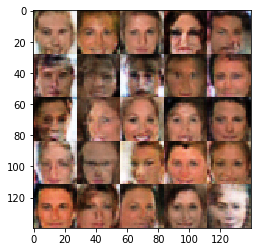

Epoch 1/1... Discriminator Loss: 1.1187... Generator Loss: 1.1153
Epoch 1/1... Discriminator Loss: 1.3163... Generator Loss: 0.6414
Epoch 1/1... Discriminator Loss: 1.2422... Generator Loss: 0.6883
Epoch 1/1... Discriminator Loss: 1.3693... Generator Loss: 0.7079
Epoch 1/1... Discriminator Loss: 1.0334... Generator Loss: 1.2875
Epoch 1/1... Discriminator Loss: 1.2921... Generator Loss: 0.6017
Epoch 1/1... Discriminator Loss: 1.0755... Generator Loss: 0.8508
Epoch 1/1... Discriminator Loss: 1.1955... Generator Loss: 1.1976
Epoch 1/1... Discriminator Loss: 1.1050... Generator Loss: 0.8768
Epoch 1/1... Discriminator Loss: 1.6118... Generator Loss: 0.4645


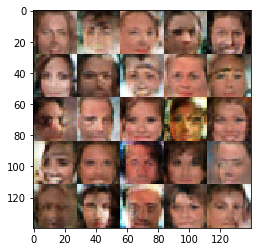

Epoch 1/1... Discriminator Loss: 1.3711... Generator Loss: 0.5674
Epoch 1/1... Discriminator Loss: 1.0188... Generator Loss: 1.0391
Epoch 1/1... Discriminator Loss: 1.0910... Generator Loss: 0.8454
Epoch 1/1... Discriminator Loss: 1.2109... Generator Loss: 0.8322
Epoch 1/1... Discriminator Loss: 1.1973... Generator Loss: 0.8493
Epoch 1/1... Discriminator Loss: 1.3094... Generator Loss: 0.6450
Epoch 1/1... Discriminator Loss: 1.3671... Generator Loss: 0.6223
Epoch 1/1... Discriminator Loss: 1.2530... Generator Loss: 0.6966
Epoch 1/1... Discriminator Loss: 1.1227... Generator Loss: 0.7207
Epoch 1/1... Discriminator Loss: 1.1331... Generator Loss: 0.8852


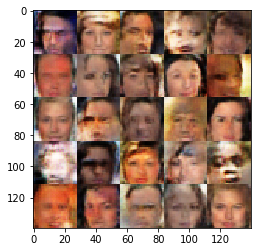

Epoch 1/1... Discriminator Loss: 0.9484... Generator Loss: 0.9867
Epoch 1/1... Discriminator Loss: 1.3139... Generator Loss: 0.6591
Epoch 1/1... Discriminator Loss: 1.1628... Generator Loss: 1.3512
Epoch 1/1... Discriminator Loss: 1.1031... Generator Loss: 0.9886
Epoch 1/1... Discriminator Loss: 1.1373... Generator Loss: 0.8378
Epoch 1/1... Discriminator Loss: 1.2990... Generator Loss: 0.6621
Epoch 1/1... Discriminator Loss: 1.0978... Generator Loss: 0.8767
Epoch 1/1... Discriminator Loss: 1.0709... Generator Loss: 0.8993
Epoch 1/1... Discriminator Loss: 1.3217... Generator Loss: 0.7047
Epoch 1/1... Discriminator Loss: 1.2320... Generator Loss: 0.6757


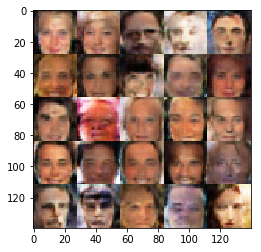

Epoch 1/1... Discriminator Loss: 1.1352... Generator Loss: 0.8567
Epoch 1/1... Discriminator Loss: 1.1322... Generator Loss: 0.8112
Epoch 1/1... Discriminator Loss: 1.3334... Generator Loss: 0.5802
Epoch 1/1... Discriminator Loss: 1.1903... Generator Loss: 0.7357
Epoch 1/1... Discriminator Loss: 1.3014... Generator Loss: 0.7613
Epoch 1/1... Discriminator Loss: 1.3979... Generator Loss: 0.6211
Epoch 1/1... Discriminator Loss: 1.0270... Generator Loss: 0.9643
Epoch 1/1... Discriminator Loss: 1.0163... Generator Loss: 1.1670
Epoch 1/1... Discriminator Loss: 1.3677... Generator Loss: 0.6290
Epoch 1/1... Discriminator Loss: 1.4024... Generator Loss: 0.5609


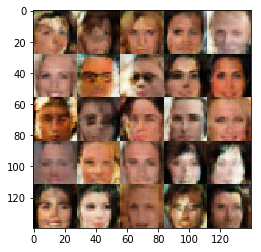

Epoch 1/1... Discriminator Loss: 1.2236... Generator Loss: 0.6702
Epoch 1/1... Discriminator Loss: 1.0601... Generator Loss: 0.8390
Epoch 1/1... Discriminator Loss: 1.3141... Generator Loss: 0.5798
Epoch 1/1... Discriminator Loss: 1.3281... Generator Loss: 0.7056
Epoch 1/1... Discriminator Loss: 1.3375... Generator Loss: 0.6893
Epoch 1/1... Discriminator Loss: 1.1986... Generator Loss: 1.0708
Epoch 1/1... Discriminator Loss: 1.3163... Generator Loss: 0.6885
Epoch 1/1... Discriminator Loss: 1.1395... Generator Loss: 0.7980
Epoch 1/1... Discriminator Loss: 1.2664... Generator Loss: 0.8672
Epoch 1/1... Discriminator Loss: 1.0724... Generator Loss: 1.0345


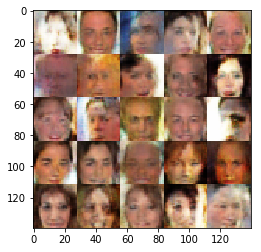

Epoch 1/1... Discriminator Loss: 1.0872... Generator Loss: 1.0244
Epoch 1/1... Discriminator Loss: 1.1596... Generator Loss: 0.8089
Epoch 1/1... Discriminator Loss: 1.3485... Generator Loss: 0.5957
Epoch 1/1... Discriminator Loss: 1.4605... Generator Loss: 0.5267
Epoch 1/1... Discriminator Loss: 1.2227... Generator Loss: 1.1360
Epoch 1/1... Discriminator Loss: 1.2306... Generator Loss: 0.6690
Epoch 1/1... Discriminator Loss: 1.1352... Generator Loss: 0.8413
Epoch 1/1... Discriminator Loss: 1.3662... Generator Loss: 0.5983
Epoch 1/1... Discriminator Loss: 1.3135... Generator Loss: 0.6384
Epoch 1/1... Discriminator Loss: 1.1925... Generator Loss: 0.8646


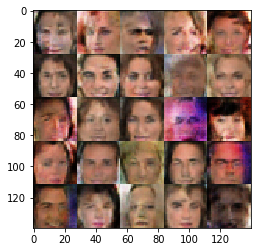

Epoch 1/1... Discriminator Loss: 1.3048... Generator Loss: 0.6833
Epoch 1/1... Discriminator Loss: 1.2701... Generator Loss: 0.6780
Epoch 1/1... Discriminator Loss: 1.2344... Generator Loss: 0.9730
Epoch 1/1... Discriminator Loss: 1.4063... Generator Loss: 0.5123
Epoch 1/1... Discriminator Loss: 0.9348... Generator Loss: 1.2359
Epoch 1/1... Discriminator Loss: 1.2914... Generator Loss: 0.6609
Epoch 1/1... Discriminator Loss: 1.2857... Generator Loss: 0.7608
Epoch 1/1... Discriminator Loss: 1.3783... Generator Loss: 0.6885
Epoch 1/1... Discriminator Loss: 1.1799... Generator Loss: 0.7478
Epoch 1/1... Discriminator Loss: 1.3465... Generator Loss: 0.7207


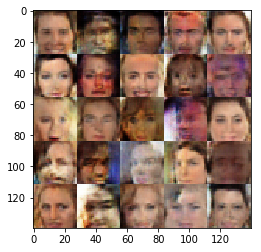

Epoch 1/1... Discriminator Loss: 1.2430... Generator Loss: 0.7546
Epoch 1/1... Discriminator Loss: 1.1501... Generator Loss: 0.7432
Epoch 1/1... Discriminator Loss: 1.1274... Generator Loss: 0.7982
Epoch 1/1... Discriminator Loss: 1.2465... Generator Loss: 0.8926
Epoch 1/1... Discriminator Loss: 1.5860... Generator Loss: 0.5041
Epoch 1/1... Discriminator Loss: 1.1201... Generator Loss: 0.8106
Epoch 1/1... Discriminator Loss: 1.4232... Generator Loss: 0.5058
Epoch 1/1... Discriminator Loss: 1.1630... Generator Loss: 0.7147
Epoch 1/1... Discriminator Loss: 1.4079... Generator Loss: 0.5369
Epoch 1/1... Discriminator Loss: 1.1924... Generator Loss: 0.6765


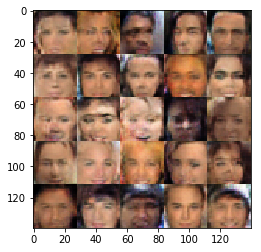

Epoch 1/1... Discriminator Loss: 1.0815... Generator Loss: 0.9571
Epoch 1/1... Discriminator Loss: 1.3677... Generator Loss: 0.6296
Epoch 1/1... Discriminator Loss: 1.0418... Generator Loss: 0.9192
Epoch 1/1... Discriminator Loss: 1.2212... Generator Loss: 0.8500
Epoch 1/1... Discriminator Loss: 0.9717... Generator Loss: 1.1794
Epoch 1/1... Discriminator Loss: 1.0378... Generator Loss: 0.9723
Epoch 1/1... Discriminator Loss: 1.2142... Generator Loss: 0.7356
Epoch 1/1... Discriminator Loss: 1.2847... Generator Loss: 0.7474
Epoch 1/1... Discriminator Loss: 1.0232... Generator Loss: 0.7672
Epoch 1/1... Discriminator Loss: 1.2068... Generator Loss: 0.6707


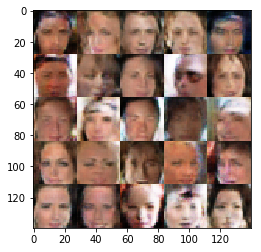

Epoch 1/1... Discriminator Loss: 1.2613... Generator Loss: 0.8955
Epoch 1/1... Discriminator Loss: 1.4124... Generator Loss: 0.5697
Epoch 1/1... Discriminator Loss: 1.1030... Generator Loss: 1.2616
Epoch 1/1... Discriminator Loss: 0.9547... Generator Loss: 1.1844
Epoch 1/1... Discriminator Loss: 1.2123... Generator Loss: 0.7535
Epoch 1/1... Discriminator Loss: 1.1302... Generator Loss: 0.9299
Epoch 1/1... Discriminator Loss: 1.4254... Generator Loss: 0.6219
Epoch 1/1... Discriminator Loss: 1.3310... Generator Loss: 0.6356
Epoch 1/1... Discriminator Loss: 1.3965... Generator Loss: 0.6072
Epoch 1/1... Discriminator Loss: 1.6258... Generator Loss: 0.4276


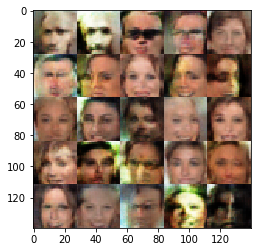

Epoch 1/1... Discriminator Loss: 1.4182... Generator Loss: 0.5536
Epoch 1/1... Discriminator Loss: 1.3376... Generator Loss: 0.6849
Epoch 1/1... Discriminator Loss: 1.3243... Generator Loss: 0.7505
Epoch 1/1... Discriminator Loss: 1.3494... Generator Loss: 0.6659
Epoch 1/1... Discriminator Loss: 0.9701... Generator Loss: 1.1959
Epoch 1/1... Discriminator Loss: 1.4322... Generator Loss: 0.5791
Epoch 1/1... Discriminator Loss: 1.2335... Generator Loss: 0.6505
Epoch 1/1... Discriminator Loss: 1.2034... Generator Loss: 0.9179
Epoch 1/1... Discriminator Loss: 1.2464... Generator Loss: 0.7933
Epoch 1/1... Discriminator Loss: 1.1986... Generator Loss: 0.7766


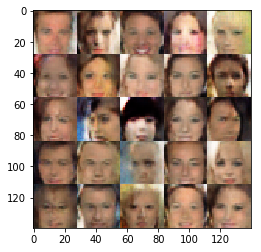

Epoch 1/1... Discriminator Loss: 1.2875... Generator Loss: 0.6692
Epoch 1/1... Discriminator Loss: 1.2280... Generator Loss: 0.8930
Epoch 1/1... Discriminator Loss: 1.2399... Generator Loss: 0.7222
Epoch 1/1... Discriminator Loss: 1.7287... Generator Loss: 0.3722
Epoch 1/1... Discriminator Loss: 1.3181... Generator Loss: 0.6382
Epoch 1/1... Discriminator Loss: 1.3341... Generator Loss: 0.7725
Epoch 1/1... Discriminator Loss: 1.3435... Generator Loss: 0.5974
Epoch 1/1... Discriminator Loss: 1.3649... Generator Loss: 0.5921
Epoch 1/1... Discriminator Loss: 1.0184... Generator Loss: 0.9726
Epoch 1/1... Discriminator Loss: 1.3644... Generator Loss: 0.6458


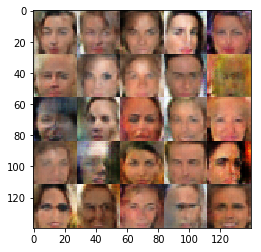

Epoch 1/1... Discriminator Loss: 1.0654... Generator Loss: 0.9437
Epoch 1/1... Discriminator Loss: 1.2146... Generator Loss: 0.9707
Epoch 1/1... Discriminator Loss: 1.3266... Generator Loss: 0.8677
Epoch 1/1... Discriminator Loss: 1.3036... Generator Loss: 0.7854
Epoch 1/1... Discriminator Loss: 1.3792... Generator Loss: 0.5229
Epoch 1/1... Discriminator Loss: 1.2262... Generator Loss: 0.7817
Epoch 1/1... Discriminator Loss: 1.3769... Generator Loss: 0.5630
Epoch 1/1... Discriminator Loss: 1.6522... Generator Loss: 0.4014
Epoch 1/1... Discriminator Loss: 1.4896... Generator Loss: 0.5214
Epoch 1/1... Discriminator Loss: 1.2072... Generator Loss: 0.7040


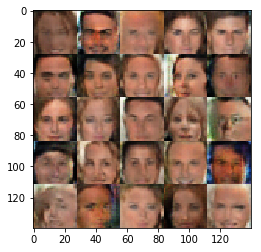

Epoch 1/1... Discriminator Loss: 1.1588... Generator Loss: 0.7902
Epoch 1/1... Discriminator Loss: 1.1151... Generator Loss: 0.7603
Epoch 1/1... Discriminator Loss: 1.1589... Generator Loss: 0.8902
Epoch 1/1... Discriminator Loss: 1.5560... Generator Loss: 0.5962
Epoch 1/1... Discriminator Loss: 1.2107... Generator Loss: 0.6562
Epoch 1/1... Discriminator Loss: 1.4361... Generator Loss: 0.5913
Epoch 1/1... Discriminator Loss: 1.1163... Generator Loss: 0.9090
Epoch 1/1... Discriminator Loss: 1.1748... Generator Loss: 0.7129
Epoch 1/1... Discriminator Loss: 1.8803... Generator Loss: 0.5229
Epoch 1/1... Discriminator Loss: 1.4194... Generator Loss: 0.5829


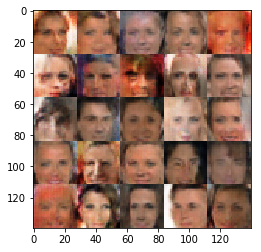

Epoch 1/1... Discriminator Loss: 1.4683... Generator Loss: 0.6226
Epoch 1/1... Discriminator Loss: 1.2000... Generator Loss: 0.7880
Epoch 1/1... Discriminator Loss: 1.2150... Generator Loss: 0.9253
Epoch 1/1... Discriminator Loss: 1.3211... Generator Loss: 0.6506
Epoch 1/1... Discriminator Loss: 1.1076... Generator Loss: 0.8804
Epoch 1/1... Discriminator Loss: 1.2896... Generator Loss: 0.6657
Epoch 1/1... Discriminator Loss: 1.0810... Generator Loss: 0.8982
Epoch 1/1... Discriminator Loss: 1.4727... Generator Loss: 0.5219
Epoch 1/1... Discriminator Loss: 1.3249... Generator Loss: 0.6185
Epoch 1/1... Discriminator Loss: 1.1352... Generator Loss: 1.1500


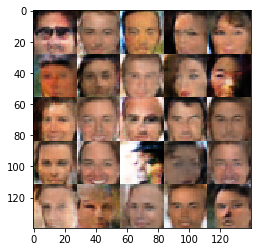

Epoch 1/1... Discriminator Loss: 1.0789... Generator Loss: 0.8682
Epoch 1/1... Discriminator Loss: 1.6025... Generator Loss: 0.4711
Epoch 1/1... Discriminator Loss: 1.3252... Generator Loss: 0.5560
Epoch 1/1... Discriminator Loss: 1.3002... Generator Loss: 0.6808
Epoch 1/1... Discriminator Loss: 1.4137... Generator Loss: 0.6279
Epoch 1/1... Discriminator Loss: 1.3417... Generator Loss: 0.6819
Epoch 1/1... Discriminator Loss: 1.3024... Generator Loss: 0.8068
Epoch 1/1... Discriminator Loss: 1.1862... Generator Loss: 0.9877
Epoch 1/1... Discriminator Loss: 1.2747... Generator Loss: 0.6310
Epoch 1/1... Discriminator Loss: 1.1623... Generator Loss: 0.8092


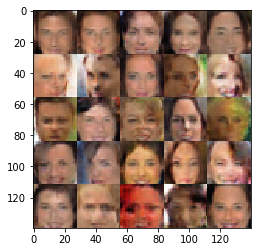

Epoch 1/1... Discriminator Loss: 1.2874... Generator Loss: 0.7699
Epoch 1/1... Discriminator Loss: 1.3258... Generator Loss: 0.8911
Epoch 1/1... Discriminator Loss: 1.4003... Generator Loss: 0.5528
Epoch 1/1... Discriminator Loss: 1.1896... Generator Loss: 0.7595
Epoch 1/1... Discriminator Loss: 1.1692... Generator Loss: 0.8785
Epoch 1/1... Discriminator Loss: 1.1891... Generator Loss: 0.8376
Epoch 1/1... Discriminator Loss: 1.1473... Generator Loss: 0.9562
Epoch 1/1... Discriminator Loss: 1.5903... Generator Loss: 0.4859
Epoch 1/1... Discriminator Loss: 1.3335... Generator Loss: 0.9160
Epoch 1/1... Discriminator Loss: 1.1716... Generator Loss: 0.7695


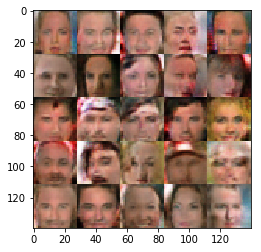

Epoch 1/1... Discriminator Loss: 1.2502... Generator Loss: 0.8563
Epoch 1/1... Discriminator Loss: 1.1754... Generator Loss: 0.7254
Epoch 1/1... Discriminator Loss: 1.3795... Generator Loss: 0.5863
Epoch 1/1... Discriminator Loss: 1.3242... Generator Loss: 0.7559
Epoch 1/1... Discriminator Loss: 1.3661... Generator Loss: 0.5595
Epoch 1/1... Discriminator Loss: 1.1012... Generator Loss: 0.9543
Epoch 1/1... Discriminator Loss: 1.0371... Generator Loss: 1.0711
Epoch 1/1... Discriminator Loss: 1.3023... Generator Loss: 0.6208
Epoch 1/1... Discriminator Loss: 1.1935... Generator Loss: 1.3142
Epoch 1/1... Discriminator Loss: 1.9300... Generator Loss: 0.3241


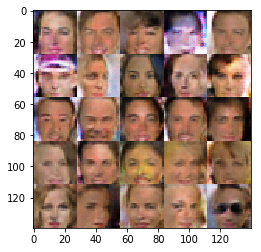

Epoch 1/1... Discriminator Loss: 1.4955... Generator Loss: 0.4957
Epoch 1/1... Discriminator Loss: 1.1865... Generator Loss: 0.6871
Epoch 1/1... Discriminator Loss: 1.1993... Generator Loss: 0.7020
Epoch 1/1... Discriminator Loss: 1.3638... Generator Loss: 0.8908
Epoch 1/1... Discriminator Loss: 1.4671... Generator Loss: 0.5143
Epoch 1/1... Discriminator Loss: 1.1811... Generator Loss: 0.8157
Epoch 1/1... Discriminator Loss: 1.2825... Generator Loss: 0.6336
Epoch 1/1... Discriminator Loss: 1.1710... Generator Loss: 0.6777
Epoch 1/1... Discriminator Loss: 1.3815... Generator Loss: 0.7379
Epoch 1/1... Discriminator Loss: 1.3417... Generator Loss: 0.7913


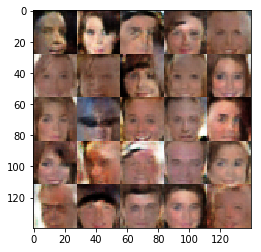

Epoch 1/1... Discriminator Loss: 1.0930... Generator Loss: 0.8127
Epoch 1/1... Discriminator Loss: 1.3120... Generator Loss: 0.6004
Epoch 1/1... Discriminator Loss: 1.4656... Generator Loss: 0.5127
Epoch 1/1... Discriminator Loss: 1.1158... Generator Loss: 1.0036
Epoch 1/1... Discriminator Loss: 1.2950... Generator Loss: 0.6755
Epoch 1/1... Discriminator Loss: 1.3810... Generator Loss: 0.6665
Epoch 1/1... Discriminator Loss: 1.3317... Generator Loss: 0.7437
Epoch 1/1... Discriminator Loss: 1.2110... Generator Loss: 0.7908
Epoch 1/1... Discriminator Loss: 1.0417... Generator Loss: 0.9455
Epoch 1/1... Discriminator Loss: 1.5062... Generator Loss: 0.4733


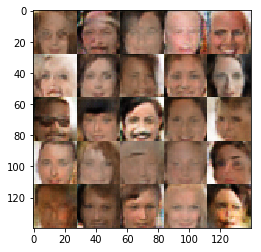

Epoch 1/1... Discriminator Loss: 1.1172... Generator Loss: 0.8689
Epoch 1/1... Discriminator Loss: 1.2140... Generator Loss: 0.7000
Epoch 1/1... Discriminator Loss: 1.5151... Generator Loss: 0.4859
Epoch 1/1... Discriminator Loss: 1.5622... Generator Loss: 0.4844
Epoch 1/1... Discriminator Loss: 1.3444... Generator Loss: 0.9209
Epoch 1/1... Discriminator Loss: 1.2171... Generator Loss: 1.2932
Epoch 1/1... Discriminator Loss: 1.0427... Generator Loss: 1.0219
Epoch 1/1... Discriminator Loss: 1.3776... Generator Loss: 0.5857
Epoch 1/1... Discriminator Loss: 1.1901... Generator Loss: 0.8333
Epoch 1/1... Discriminator Loss: 1.1587... Generator Loss: 0.7831


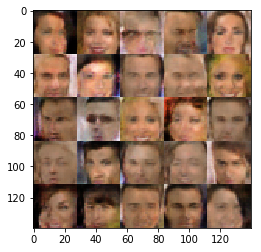

Epoch 1/1... Discriminator Loss: 1.0478... Generator Loss: 1.1655
Epoch 1/1... Discriminator Loss: 1.2417... Generator Loss: 0.7026
Epoch 1/1... Discriminator Loss: 1.4293... Generator Loss: 0.6115
Epoch 1/1... Discriminator Loss: 1.0402... Generator Loss: 0.9989
Epoch 1/1... Discriminator Loss: 1.2665... Generator Loss: 0.9116
Epoch 1/1... Discriminator Loss: 1.3662... Generator Loss: 0.7644
Epoch 1/1... Discriminator Loss: 1.0262... Generator Loss: 0.9556
Epoch 1/1... Discriminator Loss: 1.1807... Generator Loss: 0.8584
Epoch 1/1... Discriminator Loss: 0.9178... Generator Loss: 1.2563
Epoch 1/1... Discriminator Loss: 1.0360... Generator Loss: 1.0943


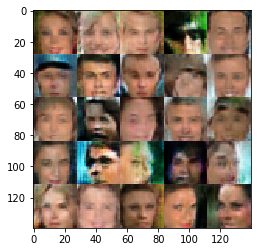

Epoch 1/1... Discriminator Loss: 1.2835... Generator Loss: 0.7028
Epoch 1/1... Discriminator Loss: 1.2823... Generator Loss: 0.7450
Epoch 1/1... Discriminator Loss: 1.0970... Generator Loss: 0.8375
Epoch 1/1... Discriminator Loss: 1.3619... Generator Loss: 0.6106
Epoch 1/1... Discriminator Loss: 1.2750... Generator Loss: 0.6350
Epoch 1/1... Discriminator Loss: 1.0451... Generator Loss: 0.8881
Epoch 1/1... Discriminator Loss: 1.3395... Generator Loss: 0.9056
Epoch 1/1... Discriminator Loss: 1.4419... Generator Loss: 0.6505
Epoch 1/1... Discriminator Loss: 1.2997... Generator Loss: 0.6140
Epoch 1/1... Discriminator Loss: 1.4081... Generator Loss: 0.4951


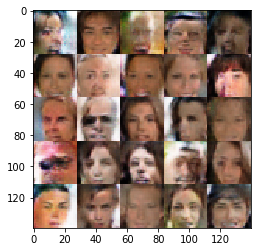

Epoch 1/1... Discriminator Loss: 1.3839... Generator Loss: 0.6488
Epoch 1/1... Discriminator Loss: 1.2125... Generator Loss: 1.0231
Epoch 1/1... Discriminator Loss: 1.5379... Generator Loss: 0.5123
Epoch 1/1... Discriminator Loss: 1.4583... Generator Loss: 0.5194
Epoch 1/1... Discriminator Loss: 1.3408... Generator Loss: 0.7214
Epoch 1/1... Discriminator Loss: 1.1950... Generator Loss: 0.7240
Epoch 1/1... Discriminator Loss: 1.1858... Generator Loss: 0.9759
Epoch 1/1... Discriminator Loss: 0.9882... Generator Loss: 1.0353
Epoch 1/1... Discriminator Loss: 1.1903... Generator Loss: 0.7479
Epoch 1/1... Discriminator Loss: 1.1005... Generator Loss: 1.4014


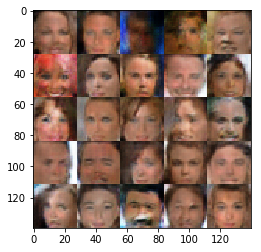

Epoch 1/1... Discriminator Loss: 1.2383... Generator Loss: 0.6682
Epoch 1/1... Discriminator Loss: 1.1839... Generator Loss: 0.7980
Epoch 1/1... Discriminator Loss: 1.3427... Generator Loss: 0.5551
Epoch 1/1... Discriminator Loss: 1.3418... Generator Loss: 0.7196
Epoch 1/1... Discriminator Loss: 1.4403... Generator Loss: 0.5656
Epoch 1/1... Discriminator Loss: 1.0394... Generator Loss: 0.9361
Epoch 1/1... Discriminator Loss: 1.1839... Generator Loss: 0.8696
Epoch 1/1... Discriminator Loss: 1.2033... Generator Loss: 0.8015
Epoch 1/1... Discriminator Loss: 1.6792... Generator Loss: 0.4691
Epoch 1/1... Discriminator Loss: 1.2859... Generator Loss: 0.7055


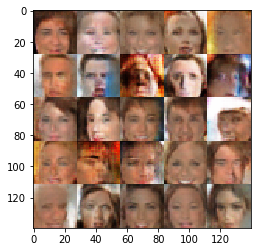

Epoch 1/1... Discriminator Loss: 1.2572... Generator Loss: 0.6870
Epoch 1/1... Discriminator Loss: 1.4077... Generator Loss: 0.5208
Epoch 1/1... Discriminator Loss: 1.3245... Generator Loss: 0.6383
Epoch 1/1... Discriminator Loss: 1.0070... Generator Loss: 0.9915
Epoch 1/1... Discriminator Loss: 1.3497... Generator Loss: 0.5794
Epoch 1/1... Discriminator Loss: 1.3171... Generator Loss: 0.6480
Epoch 1/1... Discriminator Loss: 1.0729... Generator Loss: 1.1523
Epoch 1/1... Discriminator Loss: 1.3723... Generator Loss: 0.5692
Epoch 1/1... Discriminator Loss: 1.4576... Generator Loss: 0.5063
Epoch 1/1... Discriminator Loss: 1.4666... Generator Loss: 0.6378


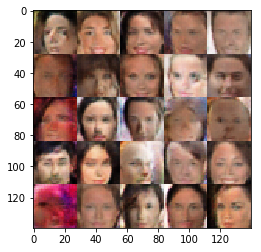

Epoch 1/1... Discriminator Loss: 0.9895... Generator Loss: 0.9975
Epoch 1/1... Discriminator Loss: 1.4848... Generator Loss: 0.5057
Epoch 1/1... Discriminator Loss: 1.2808... Generator Loss: 0.7089
Epoch 1/1... Discriminator Loss: 1.3973... Generator Loss: 0.7577
Epoch 1/1... Discriminator Loss: 1.2837... Generator Loss: 1.7265
Epoch 1/1... Discriminator Loss: 1.4465... Generator Loss: 0.7376
Epoch 1/1... Discriminator Loss: 1.1633... Generator Loss: 0.9596
Epoch 1/1... Discriminator Loss: 0.8352... Generator Loss: 1.1370
Epoch 1/1... Discriminator Loss: 1.1519... Generator Loss: 0.7352
Epoch 1/1... Discriminator Loss: 1.0503... Generator Loss: 0.7738


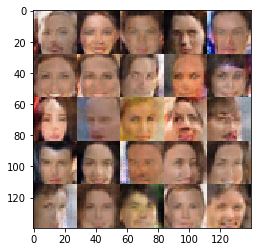

Epoch 1/1... Discriminator Loss: 1.3844... Generator Loss: 0.5501
Epoch 1/1... Discriminator Loss: 1.2474... Generator Loss: 0.7089
Epoch 1/1... Discriminator Loss: 0.9991... Generator Loss: 0.9886
Epoch 1/1... Discriminator Loss: 1.5127... Generator Loss: 0.4532
Epoch 1/1... Discriminator Loss: 1.4016... Generator Loss: 1.1309
Epoch 1/1... Discriminator Loss: 1.1672... Generator Loss: 1.2055
Epoch 1/1... Discriminator Loss: 1.2524... Generator Loss: 0.7330
Epoch 1/1... Discriminator Loss: 1.5327... Generator Loss: 0.5473
Epoch 1/1... Discriminator Loss: 1.1897... Generator Loss: 0.7614
Epoch 1/1... Discriminator Loss: 1.1607... Generator Loss: 0.7917


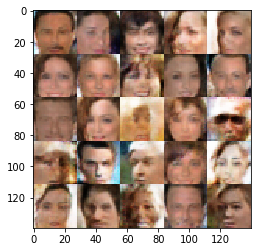

Epoch 1/1... Discriminator Loss: 1.2090... Generator Loss: 0.8279
Epoch 1/1... Discriminator Loss: 1.2536... Generator Loss: 0.6672
Epoch 1/1... Discriminator Loss: 1.1885... Generator Loss: 0.8260
Epoch 1/1... Discriminator Loss: 1.7978... Generator Loss: 0.4200
Epoch 1/1... Discriminator Loss: 1.2500... Generator Loss: 0.6494
Epoch 1/1... Discriminator Loss: 1.1788... Generator Loss: 0.8579
Epoch 1/1... Discriminator Loss: 1.5695... Generator Loss: 0.5681
Epoch 1/1... Discriminator Loss: 1.1852... Generator Loss: 0.9432
Epoch 1/1... Discriminator Loss: 0.9889... Generator Loss: 0.9409
Epoch 1/1... Discriminator Loss: 1.1089... Generator Loss: 0.7823


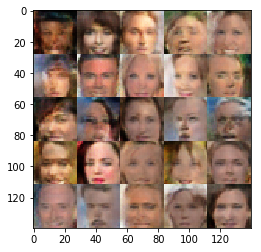

Epoch 1/1... Discriminator Loss: 1.3551... Generator Loss: 0.6839
Epoch 1/1... Discriminator Loss: 1.4054... Generator Loss: 0.7018
Epoch 1/1... Discriminator Loss: 1.2987... Generator Loss: 0.7911
Epoch 1/1... Discriminator Loss: 1.1448... Generator Loss: 0.8197
Epoch 1/1... Discriminator Loss: 1.6743... Generator Loss: 0.3573
Epoch 1/1... Discriminator Loss: 1.0525... Generator Loss: 0.8362
Epoch 1/1... Discriminator Loss: 1.3735... Generator Loss: 0.6957
Epoch 1/1... Discriminator Loss: 1.1733... Generator Loss: 0.8396
Epoch 1/1... Discriminator Loss: 1.1961... Generator Loss: 0.7695
Epoch 1/1... Discriminator Loss: 1.2266... Generator Loss: 0.9022


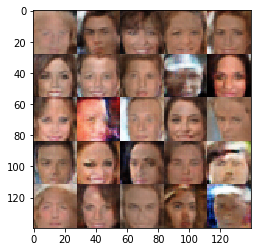

Epoch 1/1... Discriminator Loss: 1.3991... Generator Loss: 0.5767
Epoch 1/1... Discriminator Loss: 1.2662... Generator Loss: 0.6962
Epoch 1/1... Discriminator Loss: 1.0262... Generator Loss: 0.9010
Epoch 1/1... Discriminator Loss: 1.2637... Generator Loss: 0.7331
Epoch 1/1... Discriminator Loss: 1.5857... Generator Loss: 0.4921
Epoch 1/1... Discriminator Loss: 1.6454... Generator Loss: 0.5146
Epoch 1/1... Discriminator Loss: 1.3231... Generator Loss: 0.8446
Epoch 1/1... Discriminator Loss: 1.2752... Generator Loss: 0.6298
Epoch 1/1... Discriminator Loss: 1.0773... Generator Loss: 1.0420
Epoch 1/1... Discriminator Loss: 1.1773... Generator Loss: 0.9043


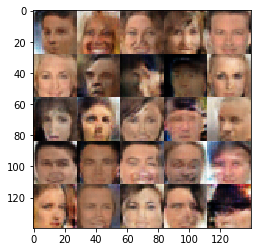

Epoch 1/1... Discriminator Loss: 1.5747... Generator Loss: 0.4976
Epoch 1/1... Discriminator Loss: 0.8701... Generator Loss: 1.4027
Epoch 1/1... Discriminator Loss: 1.1903... Generator Loss: 0.7826
Epoch 1/1... Discriminator Loss: 1.6344... Generator Loss: 0.3676
Epoch 1/1... Discriminator Loss: 1.1868... Generator Loss: 0.7510
Epoch 1/1... Discriminator Loss: 1.3387... Generator Loss: 0.6937
Epoch 1/1... Discriminator Loss: 1.2075... Generator Loss: 0.7024
Epoch 1/1... Discriminator Loss: 1.4448... Generator Loss: 1.0780
Epoch 1/1... Discriminator Loss: 1.3550... Generator Loss: 0.6600
Epoch 1/1... Discriminator Loss: 1.4076... Generator Loss: 0.5374


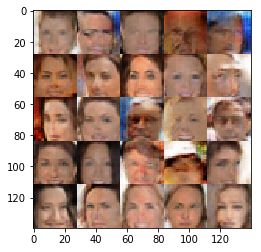

Epoch 1/1... Discriminator Loss: 1.2852... Generator Loss: 0.6741
Epoch 1/1... Discriminator Loss: 1.2555... Generator Loss: 0.7217
Epoch 1/1... Discriminator Loss: 1.1797... Generator Loss: 0.7763
Epoch 1/1... Discriminator Loss: 1.2797... Generator Loss: 0.7597
Epoch 1/1... Discriminator Loss: 1.3542... Generator Loss: 0.5314
Epoch 1/1... Discriminator Loss: 1.2640... Generator Loss: 0.6584
Epoch 1/1... Discriminator Loss: 1.1965... Generator Loss: 0.7319
Epoch 1/1... Discriminator Loss: 1.1669... Generator Loss: 1.0237
Epoch 1/1... Discriminator Loss: 1.0345... Generator Loss: 0.9117
Epoch 1/1... Discriminator Loss: 1.0054... Generator Loss: 1.1021


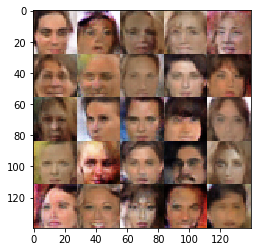

Epoch 1/1... Discriminator Loss: 1.2267... Generator Loss: 0.6798
Epoch 1/1... Discriminator Loss: 1.4037... Generator Loss: 0.5002
Epoch 1/1... Discriminator Loss: 1.3492... Generator Loss: 0.6529
Epoch 1/1... Discriminator Loss: 0.9934... Generator Loss: 0.9797
Epoch 1/1... Discriminator Loss: 1.7586... Generator Loss: 0.4481
Epoch 1/1... Discriminator Loss: 1.3473... Generator Loss: 0.7001
Epoch 1/1... Discriminator Loss: 1.3817... Generator Loss: 0.5298
Epoch 1/1... Discriminator Loss: 1.3710... Generator Loss: 0.6961
Epoch 1/1... Discriminator Loss: 1.2592... Generator Loss: 0.6950
Epoch 1/1... Discriminator Loss: 1.2759... Generator Loss: 0.8421


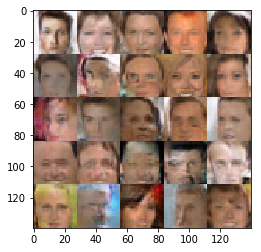

Epoch 1/1... Discriminator Loss: 1.0917... Generator Loss: 0.9324
Epoch 1/1... Discriminator Loss: 1.0795... Generator Loss: 0.8892
Epoch 1/1... Discriminator Loss: 1.4604... Generator Loss: 0.5522
Epoch 1/1... Discriminator Loss: 1.1328... Generator Loss: 0.8160
Epoch 1/1... Discriminator Loss: 1.2195... Generator Loss: 0.8386
Epoch 1/1... Discriminator Loss: 1.2211... Generator Loss: 0.7829
Epoch 1/1... Discriminator Loss: 1.3531... Generator Loss: 0.8982
Epoch 1/1... Discriminator Loss: 1.1434... Generator Loss: 0.7766
Epoch 1/1... Discriminator Loss: 1.3032... Generator Loss: 0.7234
Epoch 1/1... Discriminator Loss: 1.3418... Generator Loss: 0.6836


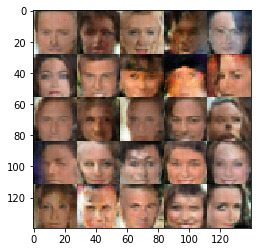

Epoch 1/1... Discriminator Loss: 1.1845... Generator Loss: 0.9707
Epoch 1/1... Discriminator Loss: 1.2805... Generator Loss: 0.5905
Epoch 1/1... Discriminator Loss: 1.8613... Generator Loss: 0.3581
Epoch 1/1... Discriminator Loss: 1.2368... Generator Loss: 0.8226
Epoch 1/1... Discriminator Loss: 1.4258... Generator Loss: 0.6926
Epoch 1/1... Discriminator Loss: 1.2946... Generator Loss: 0.7456
Epoch 1/1... Discriminator Loss: 2.0858... Generator Loss: 0.2760
Epoch 1/1... Discriminator Loss: 1.2110... Generator Loss: 0.7693
Epoch 1/1... Discriminator Loss: 1.2606... Generator Loss: 0.7991
Epoch 1/1... Discriminator Loss: 1.5709... Generator Loss: 0.4819


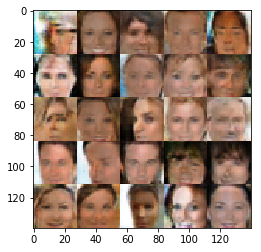

Epoch 1/1... Discriminator Loss: 1.0714... Generator Loss: 1.0797
Epoch 1/1... Discriminator Loss: 1.0763... Generator Loss: 0.9770
Epoch 1/1... Discriminator Loss: 1.3637... Generator Loss: 0.5009
Epoch 1/1... Discriminator Loss: 1.1329... Generator Loss: 0.8047
Epoch 1/1... Discriminator Loss: 1.0228... Generator Loss: 0.9109
Epoch 1/1... Discriminator Loss: 1.5364... Generator Loss: 0.4337
Epoch 1/1... Discriminator Loss: 1.4710... Generator Loss: 0.6368
Epoch 1/1... Discriminator Loss: 1.3037... Generator Loss: 0.6304
Epoch 1/1... Discriminator Loss: 1.2618... Generator Loss: 0.6150
Epoch 1/1... Discriminator Loss: 1.1348... Generator Loss: 0.7136


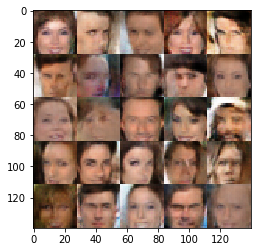

Epoch 1/1... Discriminator Loss: 1.1829... Generator Loss: 0.8063
Epoch 1/1... Discriminator Loss: 1.3190... Generator Loss: 0.5565
Epoch 1/1... Discriminator Loss: 1.4681... Generator Loss: 0.5917
Epoch 1/1... Discriminator Loss: 1.4199... Generator Loss: 0.6340
Epoch 1/1... Discriminator Loss: 1.2978... Generator Loss: 0.7274
Epoch 1/1... Discriminator Loss: 0.9911... Generator Loss: 1.0820
Epoch 1/1... Discriminator Loss: 1.4260... Generator Loss: 0.5608
Epoch 1/1... Discriminator Loss: 1.2242... Generator Loss: 0.7545
Epoch 1/1... Discriminator Loss: 1.1928... Generator Loss: 0.6761
Epoch 1/1... Discriminator Loss: 1.3899... Generator Loss: 0.6298


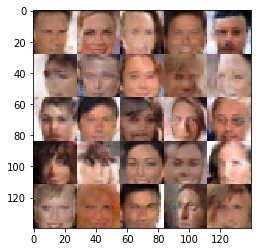

Epoch 1/1... Discriminator Loss: 1.4659... Generator Loss: 0.5505
Epoch 1/1... Discriminator Loss: 1.1256... Generator Loss: 0.8666
Epoch 1/1... Discriminator Loss: 1.2883... Generator Loss: 0.6631
Epoch 1/1... Discriminator Loss: 1.3471... Generator Loss: 0.5553
Epoch 1/1... Discriminator Loss: 1.0897... Generator Loss: 0.8145
Epoch 1/1... Discriminator Loss: 1.1986... Generator Loss: 0.7810
Epoch 1/1... Discriminator Loss: 1.2653... Generator Loss: 0.8829
Epoch 1/1... Discriminator Loss: 1.0055... Generator Loss: 0.9163
Epoch 1/1... Discriminator Loss: 1.1485... Generator Loss: 0.7138
Epoch 1/1... Discriminator Loss: 1.2678... Generator Loss: 0.7480


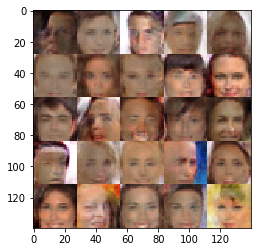

Epoch 1/1... Discriminator Loss: 1.4204... Generator Loss: 0.5141
Epoch 1/1... Discriminator Loss: 1.3195... Generator Loss: 0.7001
Epoch 1/1... Discriminator Loss: 1.2437... Generator Loss: 0.6769
Epoch 1/1... Discriminator Loss: 1.0961... Generator Loss: 1.0599
Epoch 1/1... Discriminator Loss: 1.0213... Generator Loss: 0.9900
Epoch 1/1... Discriminator Loss: 1.1836... Generator Loss: 0.7926
Epoch 1/1... Discriminator Loss: 1.0424... Generator Loss: 0.9381
Epoch 1/1... Discriminator Loss: 1.5172... Generator Loss: 0.5675
Epoch 1/1... Discriminator Loss: 1.3022... Generator Loss: 0.7093
Epoch 1/1... Discriminator Loss: 1.1765... Generator Loss: 0.7725


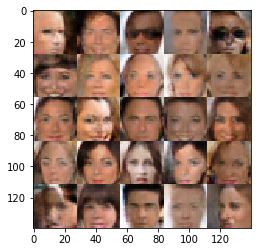

Epoch 1/1... Discriminator Loss: 1.2797... Generator Loss: 0.6825
Epoch 1/1... Discriminator Loss: 1.2491... Generator Loss: 0.6789
Epoch 1/1... Discriminator Loss: 1.4057... Generator Loss: 0.5592


In [15]:
batch_size = 32
z_dim = 100
learning_rate = 0.0002
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.